In [ ]:
import cv2
import time

from matplotlib import pyplot as plt


In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(10, 10))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.show()


In [ ]:
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    print("Original image")
    display_image(image)

    # Resize the image to a fixed size
    desired_width = 800
    aspect_ratio = image.shape[1] / image.shape[0]
    desired_height = int(desired_width / aspect_ratio)
    resized_image = cv2.resize(image, (desired_width, desired_height))

    print("Resized image")
    display_image(resized_image)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    print("Grayscale image")
    display_image(gray_image)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    print("Blurred image")
    display_image(blurred_image)

    # Apply additional preprocessing steps if needed
    # For example, you can experiment with histogram equalization,
    # thresholding, edge detection, etc.

    return blurred_image

In [ ]:
def detect_currency(test_image, training_image):
    # Create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # Preprocess the training image
    print("Preprocessing training image")
    preprocessed_training_image = preprocess_image(training_image)
    # Detect keypoints and compute descriptors for the training image
    training_keypoints, training_descriptors = sift.detectAndCompute(preprocessed_training_image, None)

    # Preprocess the test image
    print("Preprocessing test image")
    preprocessed_test_image = preprocess_image(test_image)
    # Detect keypoints and compute descriptors for the test image
    test_keypoints, test_descriptors = sift.detectAndCompute(preprocessed_test_image, None)

    # Match keypoints and descriptors between the test image and each training image
    matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = matcher.match(training_descriptors, test_descriptors)
    matches = sorted(matches, key = lambda x:x.distance)

    # Draw the matches between the test image and a training image
    matched_image = cv2.drawMatches(
        preprocessed_training_image,
        training_keypoints,
        preprocessed_test_image,
        test_keypoints,
        matches[:50],
        preprocessed_test_image,
        flags = 2,  # keypoints
        # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # keypoints with descriptors
    )
    print("Keypoint matches")
    display_image(matched_image)


In [ ]:
# Provide the paths to your training images and the test image
training_image = 'template_image.jpg'
test_image = 'input_image_1.jpg'


In [ ]:
# Set a threshold for the number of good matches required for currency detection
threshold = 10


Preprocessing training image
Original image


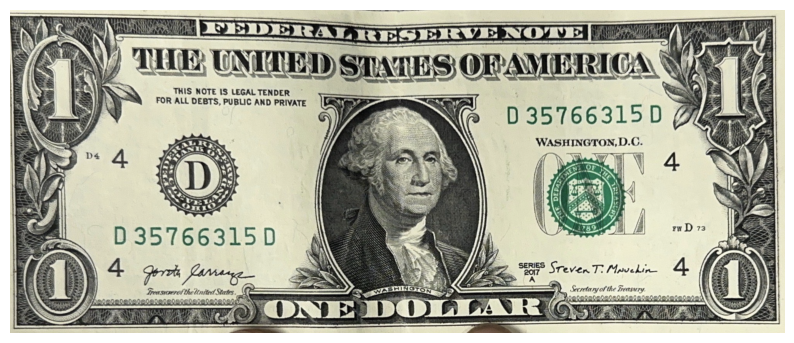

Resized image


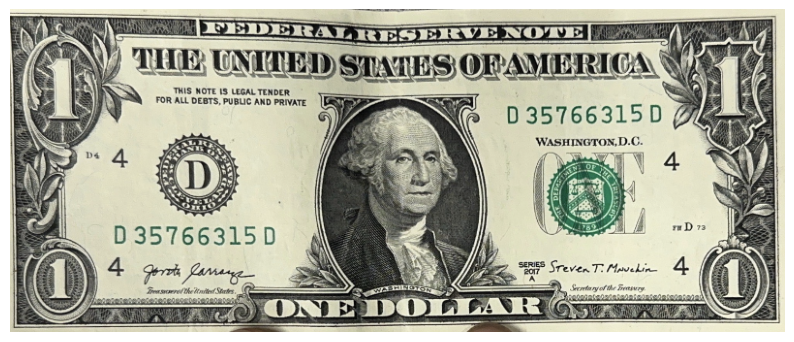

Grayscale image


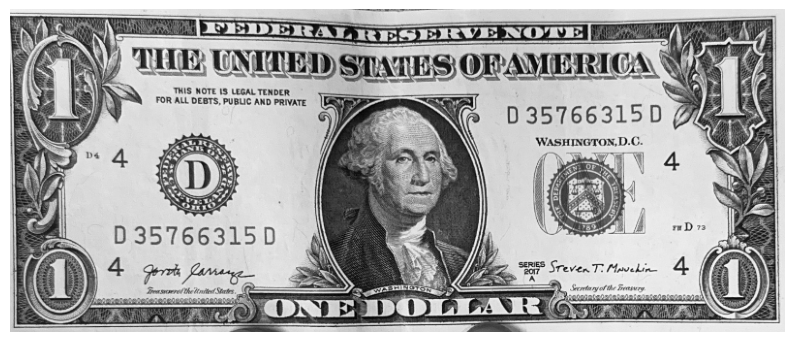

Blurred image


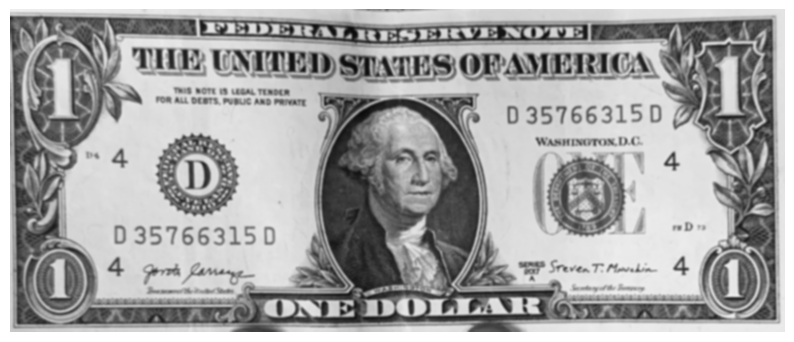

Preprocessing test image
Original image


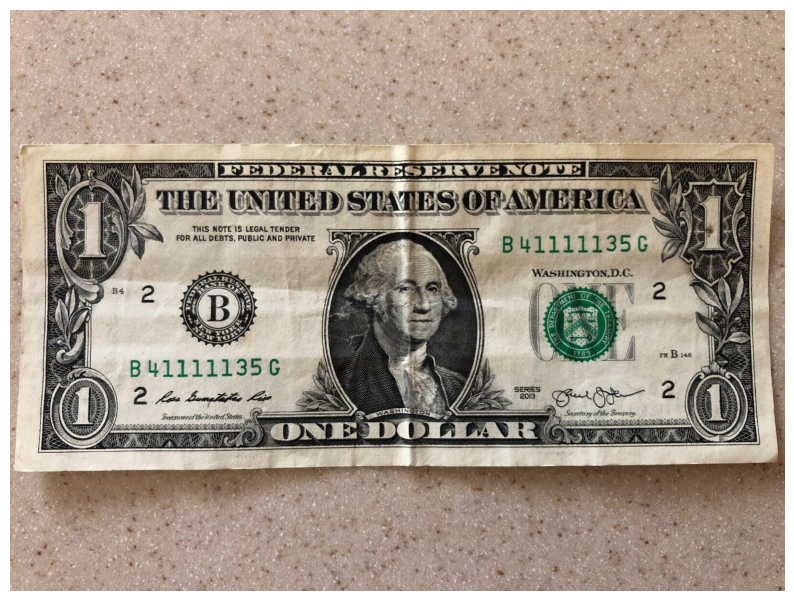

Resized image


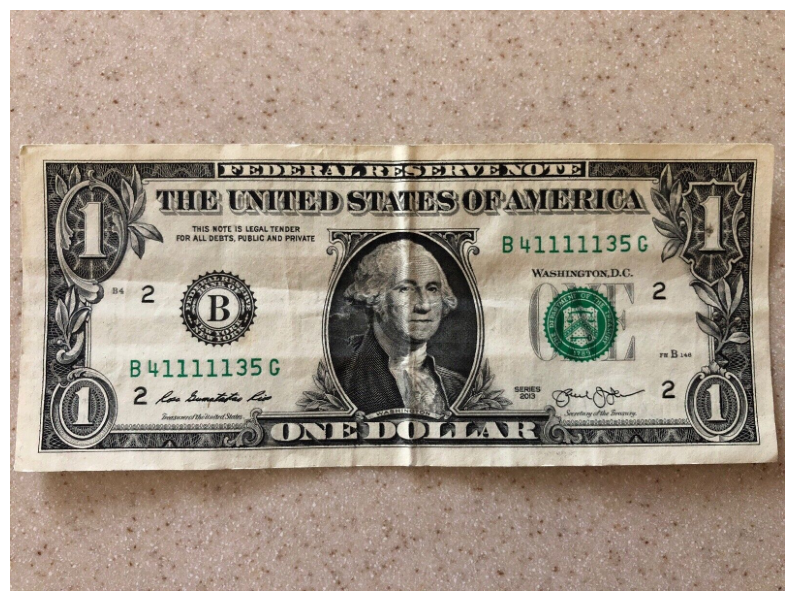

Grayscale image


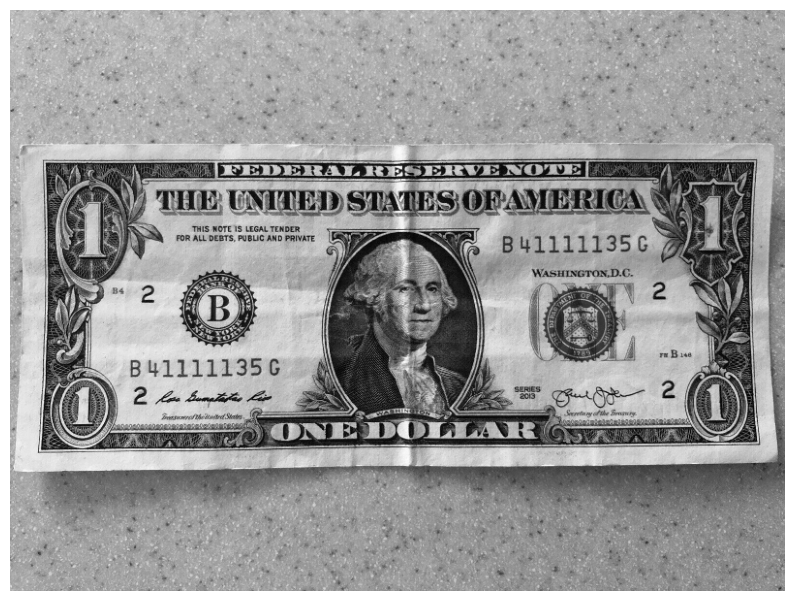

Blurred image


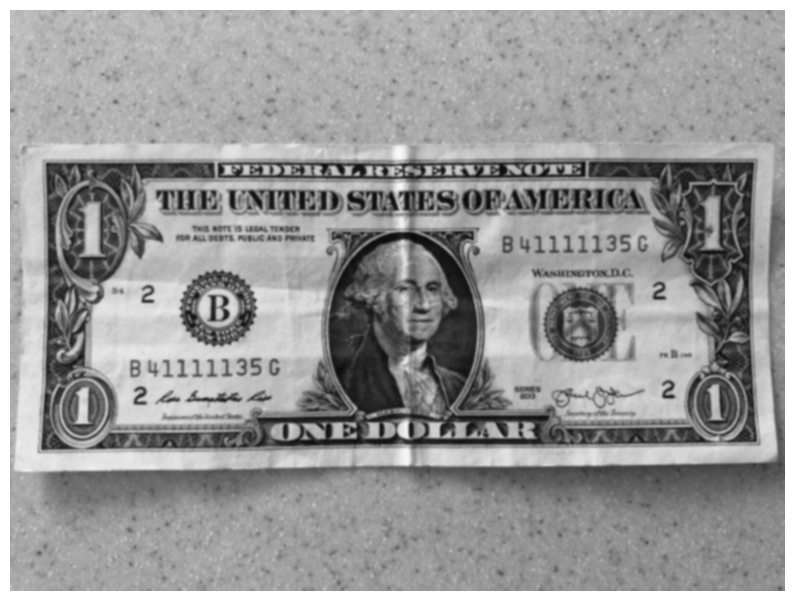

Keypoint matches


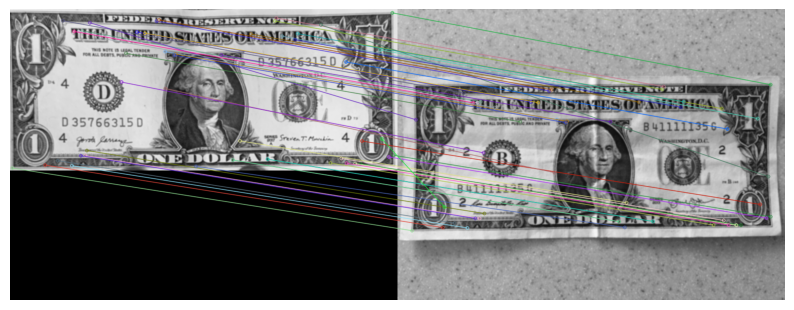

Time taken: 7.970474004745483


In [ ]:
# Call the currency detection function
start_time = time.time()
detect_currency(test_image, training_image)
end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken:", elapsed_time)


**SURF**:
This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'

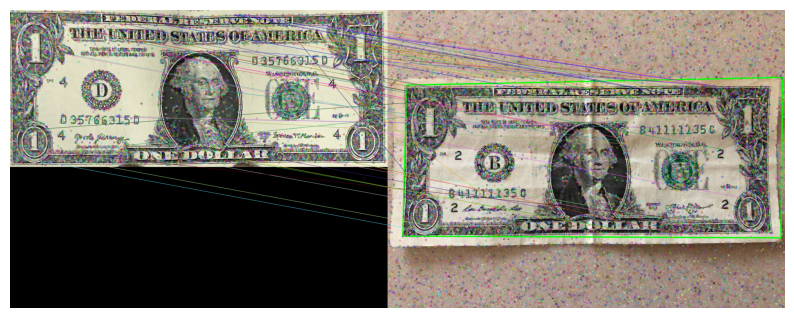

Time taken: 3.020205020904541 seconds


In [ ]:
# REFERENCE: https://stackoverflow.com/a/48207339/12202617

import cv2
import numpy as np
MIN_MATCH_COUNT = 4

imgname1 = "template_image.jpg"
imgname2 = "input_image_1.jpg"

## (1) prepare data
img1 = cv2.imread(imgname1)
img2 = cv2.imread(imgname2)

start_time = time.time()

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

## (2) Create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

## (3) Create flann matcher
matcher = cv2.FlannBasedMatcher(dict(algorithm = 1, trees = 5), {})

## (4) Detect keypoints and compute keypointer descriptors
kpts1, descs1 = sift.detectAndCompute(gray1,None)
kpts2, descs2 = sift.detectAndCompute(gray2,None)

## (5) knnMatch to get Top2
matches = matcher.knnMatch(descs1, descs2, 2)
# Sort by their distance.
matches = sorted(matches, key = lambda x:x[0].distance)

## (6) Ratio test, to get good matches.
good = [m1 for (m1, m2) in matches if m1.distance < 0.7 * m2.distance]

canvas = img2.copy()

## (7) find homography matrix
if len(good)>MIN_MATCH_COUNT:
    ## (queryIndex for the small object, trainIndex for the scene )
    src_pts = np.float32([ kpts1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kpts2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    ## find homography matrix in cv2.RANSAC using good match points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    #matchesMask2 = mask.ravel().tolist()
    h,w = img1.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    cv2.polylines(canvas,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good),MIN_MATCH_COUNT))

end_time = time.time()

## (8) drawMatches
matched = cv2.drawMatches(img1,kpts1,canvas,kpts2,good[:50],None)#,**draw_params)

## (9) Crop the matched region from scene
h,w = img1.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
perspectiveM = cv2.getPerspectiveTransform(np.float32(dst),pts)
found = cv2.warpPerspective(img2,perspectiveM,(w,h))

display_image(matched)

elapsed_time = end_time - start_time
print("Time taken:", elapsed_time, "seconds")

# REFERENCE: https://stackoverflow.com/a/48207339/12202617